
A Structured Output Agent in LangChain (or other LLM frameworks) refers to an agent that produces responses in a specific structured format, such as JSON, dictionaries, or other structured data types. These agents are particularly useful when you want to ensure that your responses conform to a defined schema, making it easier to parse, validate, and utilize in downstream applications.

Why Use a Structured Output Agent?
Controlled Responses: Ensures that the outputs follow a specific format, reducing ambiguity.
Data Validation: Useful when you want the model output to fit predefined structures, like for APIs or database entries.
Automation: Makes integration with systems like dashboards, ETL pipelines, or business workflows easier.

In [5]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [6]:
LANGSMITH_TRACING = os.getenv("LANGSMITH_TRACING")
LANGSMITH_ENDPOINT = os.getenv("LANGSMITH_ENDPOINT")
LANGSMITH_API_KEY = os.getenv("LANGSMITH_API_KEY")
LANGSMITH_PROJECT = os.getenv("LANGSMITH_PROJECT")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
# TRAVILY_PROJECT = os.getenv("TRAVILY_PROJECT")
SERPER_API_KEY = os.getenv("SERPER_API_KEY")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = os.getenv("LANGSMITH_TRACING")
os.environ["LANGSMITH_ENDPOINT"] = os.getenv("LANGSMITH_ENDPOINT")
os.environ["LANGSMITH_PROJECT"] = os.getenv("LANGSMITH_PROJECT")

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["SERPER_API_KEY"] = os.getenv("SERPER_API_KEY")



In [7]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro-latest")

In [8]:
llm.invoke("bye")

AIMessage(content='Bye! Have a great day!', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-pro-002', 'safety_ratings': []}, id='run--63552269-e7a2-4624-82ca-6528475490f9-0', usage_metadata={'input_tokens': 1, 'output_tokens': 8, 'total_tokens': 9, 'input_token_details': {'cache_read': 0}})

In [9]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from pydantic import BaseModel, Field
from langgraph.graph import MessagesState,StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage

In [10]:
tavily_tool = TavilySearchResults()

C:\Users\gagan\AppData\Local\Temp\ipykernel_22552\583234793.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_tool = TavilySearchResults()


In [11]:
@tool
def get_city_details(prompt):
    "Should do a web search to find the required city details"
    response = tavily_tool.invoke(prompt)
    return response

In [12]:
tools = [get_city_details]

In [13]:

model_with_tools = llm.bind_tools(tools)

In [14]:

class CityDetails(BaseModel):
    """Respond to the user with this"""
    state_name: str = Field(description="State name of the city")
    state_capital: str = Field(description="State capital of the city")
    country_name: str = Field(description="Country name of the city")
    country_capital: str = Field(description="Country capital of the city")

In [15]:
# Inherit 'messages' key from MessagesState, which is a list of chat messages
class AgentState(MessagesState):
    # Final structured response from the agent
    final_response: CityDetails

In [16]:
model_with_structured_output = llm.with_structured_output(CityDetails)

In [17]:


def call_model(state: AgentState):
    print(f" this is 01 input from call model {state}")
    response = model_with_tools.invoke(state['messages'])
    print(f"this is 02 response from call model  {response}")
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [18]:
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    
    # If there is no function call, then we respond to the user
    if not last_message.tool_calls:
        return "respond"
    # Otherwise if there is, we continue with the tool
    else:
        return "continue"

In [19]:
def respond(state: AgentState):
    print(f"here is 03 state from respond {state}")
    response = model_with_structured_output.invoke([HumanMessage(content=state['messages'][-1].content)])
    # We return the final answer
    print(f"this is 04 response from respond{response}")
    return {"final_response": response}

In [20]:
# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("llm", call_model)
workflow.add_node("tools", ToolNode(tools))
workflow.add_node("respond", respond)


# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("llm")

# We now add a conditional edge
workflow.add_conditional_edges(
    "llm",
    
    should_continue,
    {
        "continue": "tools",
        "respond": "respond",
    },
)

workflow.add_edge("tools", "llm")
workflow.add_edge("respond", END)
graph = workflow.compile()

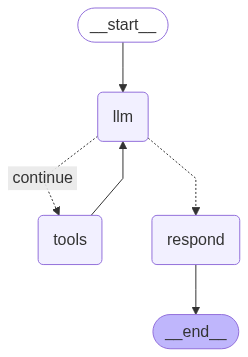

In [22]:

from IPython.display import Image, display
# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
answer = graph.invoke(input={"messages": [("human", "Tell me about the city details for gwalior?")]})['final_response']

 this is 01 input from call model {'messages': [HumanMessage(content='Tell me about the city details for gwalior?', additional_kwargs={}, response_metadata={}, id='4241401f-4040-4c17-9762-23a8b0688c9b')]}
this is 02 response from call model  content='' additional_kwargs={'function_call': {'name': 'get_city_details', 'arguments': '{"prompt": "gwalior"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-pro-002', 'safety_ratings': []} id='run--ca926fba-f883-4af1-80b7-662d2ea94f31-0' tool_calls=[{'name': 'get_city_details', 'args': {'prompt': 'gwalior'}, 'id': 'faf96482-031e-499d-a56c-254fc850773d', 'type': 'tool_call'}] usage_metadata={'input_tokens': 30, 'output_tokens': 9, 'total_tokens': 39, 'input_token_details': {'cache_read': 0}}
 this is 01 input from call model {'messages': [HumanMessage(content='Tell me about the city details for gwalior?', additional_kwargs={}, response_metadata={}, id='4241401f

In [ ]:
answer


CityDetails(state_name='Madhya Pradesh', state_capital='Bhopal', country_name='India', country_capital='New Delhi')

In [ ]:
@tool

In [50]:
from langgraph.graph import StateGraph
from langchain_core.messages import AIMessage

# First, let's define a proper tool for checking merchant status
@tool
def check_merchant_status(restaurant_id: str) -> dict:
    """
    Check the current status of a restaurant by its ID.
    Returns the status and capacity percentage.
    
    Args:
        restaurant_id: The unique identifier for the restaurant
        
    Returns:
        dict: A dictionary with status and capacity information
    """
    # In a real application, this would call an API or database
    # For demo purposes, we'll simulate a busy restaurant
    return {
        "status": "overloaded",
        "capacity": 95,
        "wait_time_minutes": 45,
        "pending_orders": 32
    }

# Create a graph instance
graph = StateGraph(MessagesState)

def manage_overloaded_restaurant(state):
    """
    Handle the case when the restaurant is overloaded.
    This function will:
    1. Check the merchant status using the provided tool
    2. Determine appropriate action based on status
    3. Update the state with a response for the user
    """
    messages = state["messages"]
    
    # Get the last user message
    last_message = messages[-1].content if messages else "No message found"
    
    # Prepare context for the LLM
    prompt = f"""
    You are assisting a restaurant management system.
    
    USER SITUATION: {last_message}
    
    Your task is to:
    1. Determine if you need to check the merchant status
    2. Based on the context, decide what action to take
    
    Respond with your analysis and recommended action.
    """
    
    # Get LLM response for analysis
    response = llm.invoke(prompt)
    
    # Now use the tool to check merchant status
    try:
        status_result = check_merchant_status.invoke({"restaurant_id": "123"})  # Using a dummy ID
        status = status_result.get("status", "unknown")
        capacity = status_result.get("capacity", 0)
        wait_time = status_result.get("wait_time_minutes", 0)
        
        # Create a detailed response based on the status
        if status == "overloaded":
            response_content = f"""
            I've checked the restaurant status and found it's currently overloaded.
            Current capacity: {capacity}%
            Estimated wait time: {wait_time} minutes
            
            Recommended actions:
            1. Temporarily pause new orders
            2. Inform customers of longer wait times
            3. Consider activating additional staff if available
            """
        elif status == "busy":
            response_content = f"""
            I've checked the restaurant status and found it's currently busy but managing.
            Current capacity: {capacity}%
            
            Recommended actions:
            1. Monitor order volume closely
            2. Prepare for possible staffing adjustments
            3. Consider slight increases in estimated delivery times
            """
        else:
            response_content = f"""
            I've checked the restaurant status and found it's operating normally.
            Current capacity: {capacity}%
            
            No special actions required at this time.
            """
            
        # Add the assistant's message to the state
        return {
            "messages": messages + [AIMessage(content=response_content)]
        }
    except Exception as e:
        # Handle any errors with the tool
        error_response = f"I tried to check the restaurant status but encountered an error: {str(e)}"
        return {
            "messages": messages + [AIMessage(content=error_response)]
        }

def notify_customer(state):
    """Notify customer about the delay"""
    messages = state["messages"]
    
    
    notification_message = """
    I've notified the customer about the delay:
    - Sent automated SMS with current wait time estimate
    - Updated the delivery ETA in their app
    - Provided a 10% discount code for their patience
    
    The customer has acknowledged the notification.
    """
    
    return {"messages": messages + [AIMessage(content=notification_message)]}

def reroute_driver(state):
    """Reroute driver to optimize delivery"""
    messages = state["messages"]
    
    reroute_message = """
    I've optimized the delivery route:
    - Rerouted the driver to avoid traffic congestion
    - Prioritized this delivery in the queue
    - Estimated time saved: 12 minutes
    
    The driver has confirmed the new route.
    """
    
    return {"messages": messages + [AIMessage(content=reroute_message)]}

def get_nearby_merchants(state):
    """Find alternative merchants nearby"""
    messages = state["messages"]
    
    merchants_message = """
    I've found 3 alternative merchants within 2 miles that offer similar menu items:
    1. Tasty Bites (1.2 miles) - 15 min wait time
    2. Quick Eats (1.5 miles) - 10 min wait time
    3. Fresh Delights (1.8 miles) - 20 min wait time
    
    Would you like me to suggest these options to the customer?
    """
    
    return {"messages": messages + [AIMessage(content=merchants_message)]}

# Define the routing function
def router(state):
    """Route to the next step based on the current state"""
    messages = state["messages"]
    last_message = messages[-1].content.lower() if messages else ""
    
    if "overloaded" in last_message or "busy" in last_message:
        return "manage_overloaded_restaurant"
    elif "reroute" in last_message and "driver" in last_message:
        return "reroute_driver"
    elif "alternative" in last_message and "merchant" in last_message:
        return "get_nearby_merchants"
    elif "wait time" in last_message or "delay" in last_message:
        return "notify_customer"
    else:
        return END

# Add nodes to the graph
graph.add_node("manage_overloaded_restaurant_agent", manage_overloaded_restaurant)
graph.add_node("notify_customer", notify_customer)
graph.add_node("reroute_driver", reroute_driver)
graph.add_node("get_nearby_merchants", get_nearby_merchants)

# Set entry point
graph.set_entry_point("manage_overloaded_restaurant")

# Add conditional edges from each node
graph.add_edge("manage_overloaded_restaurant_agent", "notify_customer")
graph.add_edge("notify_customer", "manage_overloaded_restaurant_agent")
graph.add_conditional_edges(
    "manage_overloaded_restaurant_agent", 
    router,
    {
        
        "reroute_driver": "reroute_driver",
        "get_nearby_merchants": "get_nearby_merchants"
    }
)

graph.add_edge("get_nearby_merchants", "notify_customer")



# Add default END edges for all nodes

graph.add_edge("reroute_driver", END)

# Compile the graph
restaurant_workflow = graph.compile()

ValueError: Found edge ending at unknown node `manage_overloaded_restaurant`

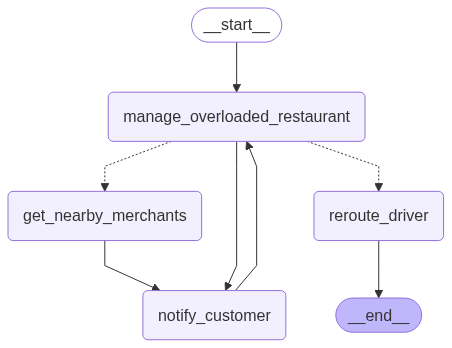

=== Running Restaurant Overload Workflow ===
Error running workflow: 'manage_overloaded_restaurant'
Error running workflow: 'manage_overloaded_restaurant'


In [51]:
from IPython.display import Image, display

# Visualize the restaurant workflow
try:
    display(Image(restaurant_workflow.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error visualizing graph: {e}")

# Run the workflow
try:
    print("=== Running Restaurant Overload Workflow ===")
    result = restaurant_workflow.invoke({"messages": [HumanMessage(content="The restaurant is experiencing high order volume")]})
    print("\n=== Final State ===")
    for i, msg in enumerate(result['messages']):
        print(f"Message {i+1}: {msg.content}")
except Exception as e:
    print(f"Error running workflow: {e}")

In [ ]:
# Test with a specific scenario
specific_scenario = restaurant_workflow.invoke({
    "messages": [HumanMessage(content="We have a major event in town and our restaurant is getting overwhelmed with orders. Customers are complaining about long wait times.")]
})

print("\n=== Specific Scenario Results ===")
for i, msg in enumerate(specific_scenario['messages']):
    print(f"\nMessage {i+1}: {msg.content}")

In [ ]:
# Let's create a version of the graph with tracing to see how it's executing
from langgraph.graph import StateGraph

# Create a traced version of the graph
traced_graph = StateGraph(MessagesState)

# Function to add tracing to node output
def add_tracing(original_function, node_name):
    def traced_function(state):
        print(f"\n>>> Executing node: {node_name}")
        result = original_function(state)
        print(f"<<< Completed node: {node_name}")
        return result
    return traced_function

# Add traced nodes
traced_graph.add_node("manage_overloaded_restaurant", 
                     add_tracing(manage_overloaded_restaurant, "manage_overloaded_restaurant"))
traced_graph.add_node("notify_customer", 
                     add_tracing(notify_customer, "notify_customer"))
traced_graph.add_node("reroute_driver", 
                     add_tracing(reroute_driver, "reroute_driver"))
traced_graph.add_node("get_nearby_merchants", 
                     add_tracing(get_nearby_merchants, "get_nearby_merchants"))

# Set up the same structure as the original graph
traced_graph.set_entry_point("manage_overloaded_restaurant")

traced_graph.add_conditional_edges(
    "manage_overloaded_restaurant", 
    router,
    {
        "notify_customer": "notify_customer",
        "reroute_driver": "reroute_driver",
        "get_nearby_merchants": "get_nearby_merchants"
    }
)

traced_graph.add_conditional_edges(
    "notify_customer", 
    router,
    {
        "reroute_driver": "reroute_driver",
        "get_nearby_merchants": "get_nearby_merchants"
    }
)

traced_graph.add_conditional_edges(
    "reroute_driver", 
    router,
    {
        "get_nearby_merchants": "get_nearby_merchants"
    }
)

traced_graph.add_edge("get_nearby_merchants", END)

# Compile the traced graph
traced_restaurant_workflow = traced_graph.compile()

# Test with the traced workflow
print("\n=== Running Traced Restaurant Overload Workflow ===")
traced_result = traced_restaurant_workflow.invoke({
    "messages": [HumanMessage(content="We have a VIP customer whose order is delayed due to kitchen overload. They've been waiting for 40 minutes.")]
})

print("\n=== Final State from Traced Workflow ===")
for i, msg in enumerate(traced_result['messages']):
    if i > 0:  # Skip the initial input message
        print(f"\nStep {i}: {msg.content}")

In [44]:
import os
from typing import TypedDict, Literal
from langchain_core.messages import BaseMessage, AIMessage, HumanMessage
from langgraph.graph import StateGraph, END
from langchain_core.tools import tool

# --- 1. Define the State for the Graph ---
# This dictionary holds all the data that moves through the graph.
# Using a TypedDict makes it clear what data to expect at each step.

class OrderWorkflowState(TypedDict):
    messages: list[BaseMessage]
    wait_time: int
    customer_response: str

# --- 2. Define Tools ---
# These are the actions the agent can take.

@tool
def check_merchant_status(restaurant_id: str) -> dict:
    """
    Check the current status of a restaurant by its ID.
    Returns the estimated wait time in minutes.
    """
    # In a real application, this would call an API.
    # We simulate a 45-minute wait time for the "delayed" path.
    # To test the "on-time" path, change this value to be less than 30.
    print("---TOOL: Checking merchant status---")
    return {"wait_time_minutes": 45}

# --- 3. Define Node Functions ---
# Each function is a step in the graph. It takes the current state,
# performs an action, and returns a dictionary to update the state.

def get_merchant_status(state: OrderWorkflowState) -> OrderWorkflowState:
    """
    Entry point node: Calls the tool to get the order's preparation time.
    """
    print("---NODE: Get Merchant Status---")
    status_result = check_merchant_status.invoke({"restaurant_id": "123"})
    wait_time = status_result.get("wait_time_minutes", 0)
    
    # The wait_time is saved to the state, which the next router will use.
    return {"wait_time": wait_time}

def notify_customer_ontime(state: OrderWorkflowState) -> OrderWorkflowState:
    """
    Node for when the order is on time.
    """
    print("---NODE: Notify Customer (On Time)---")
    message = AIMessage(content="Good news! Your order is on schedule and should be ready soon.")
    return {"messages": state["messages"] + [message]}

def notify_delayed_and_ask_customer(state: OrderWorkflowState) -> OrderWorkflowState:
    """
    Node for when the order is delayed. It notifies the customer and asks
    them to choose a new merchant or wait.
    """
    print("---NODE: Notify Customer (Delayed) & Ask for Choice---")
    wait_time = state['wait_time']
    
    # Generate the message for the customer
    notification_message = AIMessage(
        content=f"Apologies, your order is delayed. The estimated wait time is {wait_time} minutes. "
                "Would you like to switch to a nearby merchant? (yes/no)"
    )
    
    # In a real app, you would wait for user input here. We'll simulate it.
    # Change this to "yes" to test the path where the customer switches merchants.
    simulated_customer_response = "no"
    print(f"  [Simulated User Input] Customer responded: '{simulated_customer_response}'")
    
    # The customer's response is saved to the state for the next router.
    return {
        "messages": state["messages"] + [notification_message],
        "customer_response": simulated_customer_response
    }

def find_new_merchant(state: OrderWorkflowState) -> OrderWorkflowState:
    """
    Node for when the customer wants to find a new merchant.
    """
    print("---NODE: Find New Merchant---")
    message = AIMessage(content="No problem. I am searching for alternative merchants for you now.")
    # In a real app, you would call a tool here to find nearby merchants.
    return {"messages": state["messages"] + [message]}

def reroute_driver(state: OrderWorkflowState) -> OrderWorkflowState:
    """
    Node for when the customer decides to wait. It tells the driver to
    find a faster route.
    """
    print("---NODE: Reroute Driver---")
    message = AIMessage(content="Understood. We've instructed the driver to take a faster route to minimize the delay.")
    # In a real app, you would call a logistics API here.
    return {"messages": state["messages"] + [message]}


# --- 4. Define Conditional Routers ---
# These functions direct the flow of the graph based on the state.

def check_if_delayed(state: OrderWorkflowState) -> Literal["on_time", "delayed"]:
    """
    Router 1: Checks the wait time and decides if the order is delayed.
    """
    print("---ROUTER: Is order delayed?---")
    wait_time = state['wait_time']
    if wait_time < 30:
        print(f"  [Decision] Wait time is {wait_time} mins. Routing to 'on_time'.")
        return "on_time"
    else:
        print(f"  [Decision] Wait time is {wait_time} mins. Routing to 'delayed'.")
        return "delayed"

def handle_customer_choice(state: OrderWorkflowState) -> Literal["find_new", "wait"]:
    """
    Router 2: Checks the customer's response and routes to the appropriate action.
    """
    print("---ROUTER: What did the customer choose?---")
    response = state.get("customer_response", "").lower()
    if response == "yes":
        print("  [Decision] Customer chose 'yes'. Routing to 'find_new'.")
        return "find_new"
    else:
        print("  [Decision] Customer chose 'no'. Routing to 'wait'.")
        return "wait"

# --- 5. Build the Graph ---

graph_builder = StateGraph(OrderWorkflowState)

# Add all the nodes
graph_builder.add_node("get_merchant_status", get_merchant_status)
graph_builder.add_node("notify_customer_ontime", notify_customer_ontime)
graph_builder.add_node("notify_delayed_and_ask_customer", notify_delayed_and_ask_customer)
graph_builder.add_node("find_new_merchant", find_new_merchant)
graph_builder.add_node("reroute_driver", reroute_driver)

# Set the entry point
graph_builder.set_entry_point("get_merchant_status")

# Add the first conditional edge based on wait time
graph_builder.add_conditional_edges(
    start_node_key="get_merchant_status",
    condition=check_if_delayed,
    conditional_edge_mapping={
        "on_time": "notify_customer_ontime",
        "delayed": "notify_delayed_and_ask_customer"
    }
)

# Add the second conditional edge based on customer's choice
graph_builder.add_conditional_edges(
    start_node_key="notify_delayed_and_ask_customer",
    condition=handle_customer_choice,
    conditional_edge_mapping={
        "find_new": "find_new_merchant",
        "wait": "reroute_driver"
    }
)

# Add the final edges that lead to the end of the workflow
graph_builder.add_edge("notify_customer_ontime", END)
graph_builder.add_edge("find_new_merchant", END)
graph_builder.add_edge("reroute_driver", END)

# Compile the graph
restaurant_workflow = graph_builder.compile()

TypeError: StateGraph.add_conditional_edges() got an unexpected keyword argument 'start_node_key'

In [45]:
# Example: Extending the workflow with memory

# First, let's define a state that includes memory
from typing import TypedDict, List, Dict, Optional
from typing_extensions import NotRequired

class RestaurantState(TypedDict):
    messages: List  # Chat messages
    memory: NotRequired[Dict]  # Persistent memory across graph runs

# Create a function to initialize memory
def initialize_memory(state: RestaurantState) -> RestaurantState:
    """Initialize the memory if it doesn't exist"""
    if "memory" not in state:
        state["memory"] = {
            "order_volume": 0,
            "customer_notified": False,
            "driver_rerouted": False,
            "alternative_merchants_suggested": False,
            "actions_taken": []
        }
    return state

# Example of a function that uses and updates memory
def process_restaurant_status_with_memory(state: RestaurantState) -> RestaurantState:
    """Process restaurant status and update memory"""
    # First initialize memory if needed
    state = initialize_memory(state)
    
    messages = state["messages"]
    memory = state["memory"]
    
    # Get the last user message
    last_message = messages[-1].content if messages else "No message found"
    
    # Check restaurant status
    status_result = check_merchant_status.invoke({"restaurant_id": "123"})
    
    # Update memory with new information
    memory["order_volume"] = status_result.get("pending_orders", 0)
    memory["last_checked_time"] = "2023-06-15T15:30:00Z"  # In real app, use current timestamp
    
    # Record this action
    memory["actions_taken"].append("Checked restaurant status")
    
    # Create response based on status and memory
    if memory["customer_notified"]:
        response = f"""
        I've already notified the customer about the delay.
        Current order volume: {memory["order_volume"]} pending orders
        
        What would you like me to do next?
        """
    else:
        response = f"""
        I've checked the restaurant status. There are {memory["order_volume"]} pending orders.
        The customer has not been notified yet about potential delays.
        
        Would you like me to notify them?
        """
    
    return {
        "messages": messages + [AIMessage(content=response)],
        "memory": memory
    }

# This demonstrates how you could extend the restaurant workflow with persistent memory
# To implement a full memory-enabled workflow, you would:
# 1. Update the StateGraph to use RestaurantState
# 2. Modify all node functions to initialize and update memory
# 3. Use memory to make smarter routing decisions

print("\n=== Example of Memory-Enabled Restaurant Workflow ===")
# Example usage of the memory-enabled function
example_state = {
    "messages": [HumanMessage(content="Check on the status of our restaurant")]
}
result_state = process_restaurant_status_with_memory(example_state)

print("\nInitial Message:")
print(example_state["messages"][0].content)

print("\nResponse with Memory:")
print(result_state["messages"][1].content)

print("\nMemory State:")
for key, value in result_state["memory"].items():
    print(f"{key}: {value}")


=== Example of Memory-Enabled Restaurant Workflow ===
---TOOL: Checking merchant status---

Initial Message:
Check on the status of our restaurant

Response with Memory:

        I've checked the restaurant status. There are 0 pending orders.
        The customer has not been notified yet about potential delays.
        
        Would you like me to notify them?
        

Memory State:
order_volume: 0
customer_notified: False
driver_rerouted: False
alternative_merchants_suggested: False
actions_taken: ['Checked restaurant status']
last_checked_time: 2023-06-15T15:30:00Z
